In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
 
# Common imports
import numpy as np
import scipy as sp
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-dark")
sns.set_palette("bright")

mpl.rc('axes', labelsize=14, titlesize=16)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
import pandas as pd
data = pd.read_csv("/home/claym0re/Projects/python3/machine-learning/ml-algorithms/datasets/house-prices/train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X = data[["SalePrice", "LotArea", "GrLivArea"]].to_numpy().reshape(-1,3)
y = np.where(data["YearBuilt"]>=1980, 1, 0).reshape(-1,)

X_train, X_test, y_train, y_test = X[:1024], X[1025:], y[:1024], y[1025:]

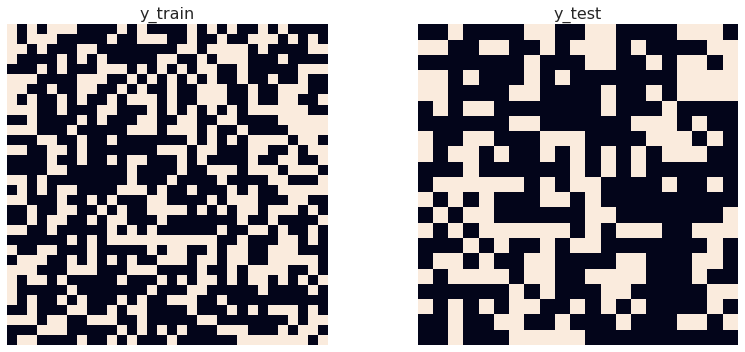

In [4]:
def plot_labels(y, ax=None):
    square_shape = int(np.ceil(np.sqrt(y.shape[0])))
    ys = y.copy()
    ys.resize(square_shape, square_shape)
    sns.heatmap(ys, square=True, cbar=False, xticklabels=False, yticklabels=False, ax=ax)

fig = plt.figure(figsize= (12,5))
ax1 = plt.subplot(121, title="y_train")
plot_labels(y_train, ax1)
ax2 = plt.subplot(122, title="y_test")
plot_labels(y_test, ax2)
plt.tight_layout()

In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None, n_values=None, depth=0):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.depth = depth
        self.pos = None
        self.n_values = n_values
        
    def is_leaf(self):
        if self.value is not None:
            self.pos = "Leaf"
            return True
    
    def _pos(self, string):
        self.pos = string

In [6]:
class DecisionTree:
    def __init__(self, min_samples_leaf=2, max_depth=100, n_feats=None, **kwarg):
        self.min_samples = min_samples_leaf
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        self.nodes = []
    
    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self._classes = np.unique(y)
        self.root = self._grow(X, y)
    
    def predict(self, X, method="majority"):
        if method == "majority":
            values = self.predict_proba(X, return_values=True)
        return np.array([self.majority_vote(v) for v in values])
    
    def predict_proba(self, X, return_values=False):
        probas = []
        values = []
        for Xi in X:
            value, counts = self.climb(Xi, self.root)
            probas.append(value/counts)
            values.append(value)
        
        if return_values:
            return np.array(values, dtype="int")
        else:
            return np.array(probas)
    
    def entropy(self, y):
        bins = np.bincount(y)
        P = bins / y.shape[0]
        entropy = 0.0
        for p in P:
            if p > 0:
                entropy -= p * np.log2(p)
    
        return entropy
    
    def climb(self, Xi, node):
        if node.is_leaf():
            return node.value, np.sum(node.value)
            
        if Xi[node.feature] <= node.threshold:
            if node is not self.root:
                node._pos("Left")
            else:
                node._pos("Root")
            return self.climb(Xi, node.left)
            
        else:
            node._pos("Right")
            return self.climb(Xi, node.right)
        
            
    
    def _grow(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        if (depth >= self.max_depth or n_classes==1 or n_samples<self.min_samples):
            values = self.get_counts(y)
            n_values = y.shape[0]
            node = Node(value=values, n_values=n_values , depth=depth)
            self.nodes.append(node)
            return node
        
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)
        
        info, threshold, j = self._gsearch(X, y, feat_idxs)
        
        left_idx, right_idx = self._fork(X[:,j], threshold)
        
        left_leaf = self._grow(X[left_idx,:], y[left_idx], depth+1)
        right_leaf = self._grow(X[right_idx,:], y[right_idx], depth+1)
        
        node = Node(j, threshold, left_leaf, right_leaf, depth=depth)
        self.nodes.append(node)
        
        
        return node
    
    @staticmethod 
    def majority_vote(counts, b=False):
        if b:
            counts = np.bincount(counts)
        
        return np.argmax(counts)
    
    def get_counts(self, y):
        l, counts = np.unique(y, return_counts=True)
        n_classes_ = len(self._classes)
        if len(l)<n_classes_:
            zeros = np.zeros([1, n_classes_]).flatten()
            zeros[l] = int(counts)
            return zeros
        else:
            return counts

    def _gsearch(self, X, y, feat_idxs):
        b_info = -1
        b_thresh, b_idx = None, None
        for idx in feat_idxs:
            Xj = X[:, idx]
            for thresh in np.unique(Xj):
                info = self._information(y, Xj, thresh)
                if info > b_info:
                    b_info = info
                    b_thresh = thresh
                    b_idx = idx
        
        return b_info, b_thresh, b_idx
    
    def _information(self, y, Xj, threshold):
        n = y.shape[0]
        parent_entropy = self.entropy(y)
        
        
        left_idx, right_idx = self._fork(Xj, threshold)
        n_left, n_right = len(left_idx), len(right_idx)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        left_entropy = self.entropy(y[left_idx])
        right_entropy = self.entropy(y[right_idx])
        
        child_entropy = (n_left/n) * left_entropy + (n_right/n) * right_entropy
        
        return parent_entropy - child_entropy
        
        
    def _fork(self, Xj, threshold):
        left_idxs = np.argwhere(Xj<=threshold).flatten()
        right_idxs = np.argwhere(Xj>threshold).flatten()
        
        return left_idxs, right_idxs

In [7]:
def accuracy_score(y_pred, y):
    return np.sum(y_pred== y)/ y.shape[0]

In [121]:
tree = DecisionTree(min_samples_leaf=3, max_depth=4)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [122]:
print("Scratch Decision Tree Accuracy: ", accuracy_score(y_pred, y_test))

Scratch Decision Tree Accuracy:  0.8390804597701149


In [10]:
tree.predict_proba(X_train)

array([[0.06198347, 0.93801653],
       [0.19008264, 0.80991736],
       [0.06198347, 0.93801653],
       ...,
       [0.19008264, 0.80991736],
       [1.        , 0.        ],
       [0.19008264, 0.80991736]])

In [11]:
def print_tree(nodes):
        for node in nodes:
            print(f"{node.pos} \nX[:,{node.feature}] \nThreshold: {node.threshold} \nDepth: {node.depth}\n--------\n")
        print(f"Number of Nodes = {len(nodes)}")
print_tree(tree.nodes[::-1])

Right 
X[:,0] 
Threshold: 172000 
Depth: 0
--------

Left 
X[:,1] 
Threshold: 15431 
Depth: 1
--------

Left 
X[:,0] 
Threshold: 311500 
Depth: 2
--------

Left 
X[:,1] 
Threshold: 53504 
Depth: 3
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Left 
X[:,0] 
Threshold: 267000 
Depth: 3
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Left 
X[:,0] 
Threshold: 200100 
Depth: 2
--------

Left 
X[:,2] 
Threshold: 2612 
Depth: 3
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Left 
X[:,2] 
Threshold: 1800 
Depth: 3
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Leaf 
X[:,None] 
Threshold: None 
Depth: 4
--------

Left 
X[:,0] 
Threshold: 118000 
Depth: 1
--------

Right 
X[:,1] 
Threshold: 4500 
Depth: 2
--------

Left 
X[:,2] 
Threshold: 1572 
Depth: 3
--------

Leaf 
X[:,No

In [12]:
from sklearn.tree import DecisionTreeClassifier

sk_tree = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=2, max_depth=3, random_state=42)
sk_tree.fit(X_train, y_train)
sk_pred = sk_tree.predict(X_test)

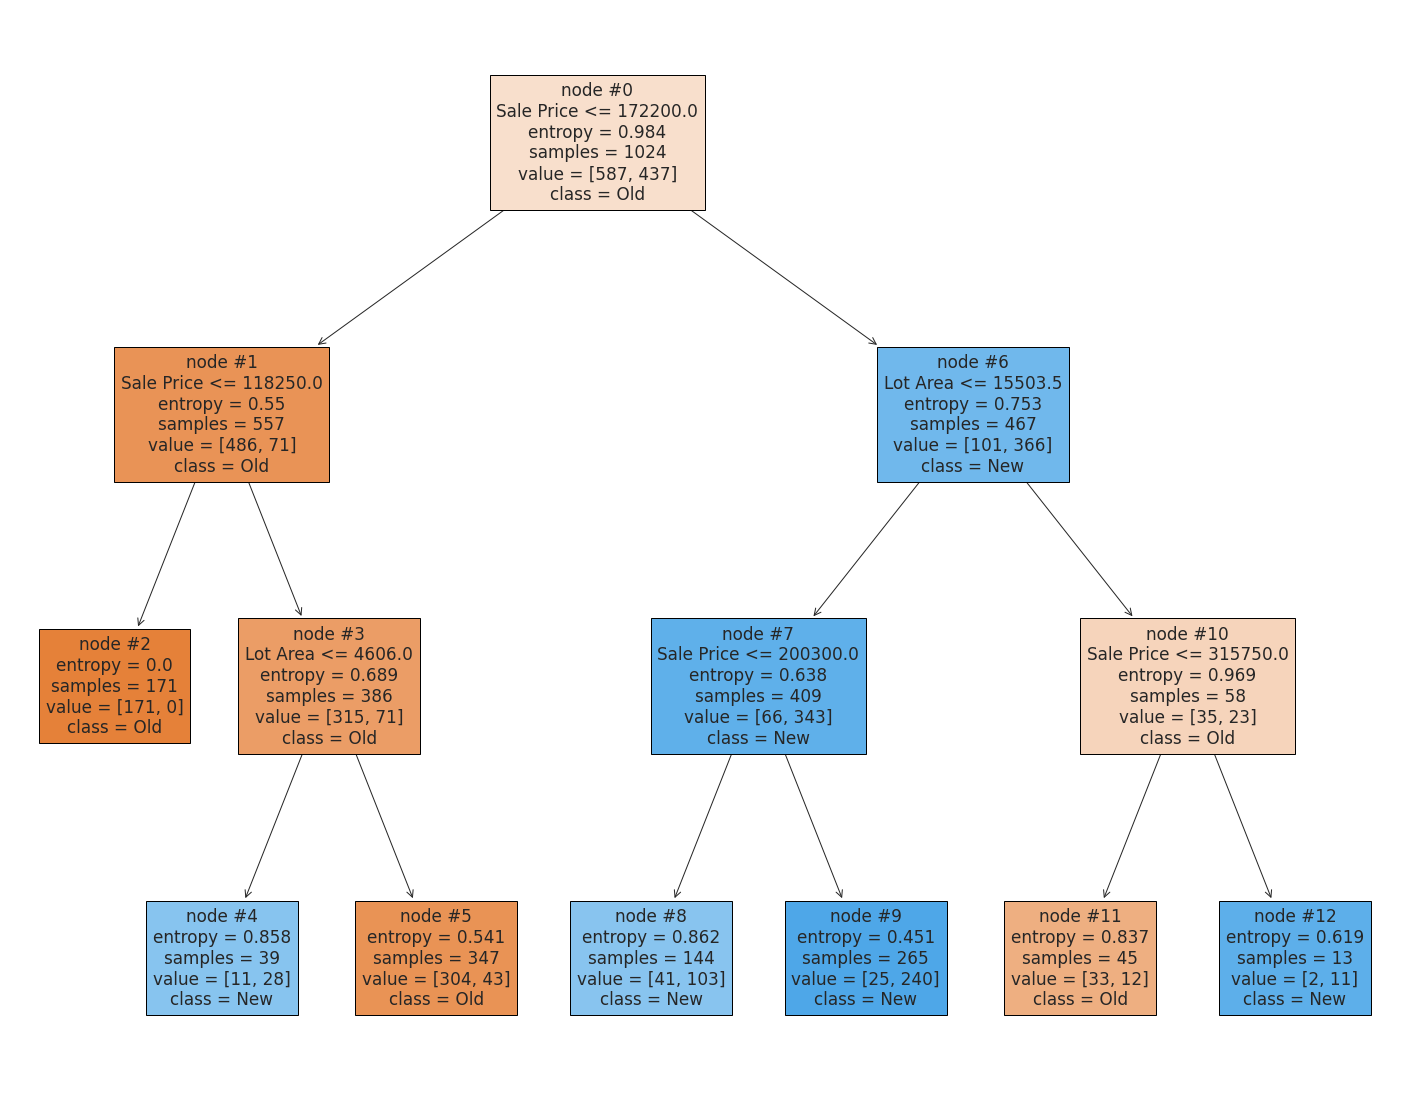

In [13]:
fig = plt.figure(figsize=(25,20))
sklearn.tree.plot_tree(sk_tree, filled=True, feature_names=["Sale Price", "Lot Area", "Living Area"], class_names=["Old", "New"],node_ids=True, )
plt.show()

In [14]:
print("SKLearn Decision Tree Accuracy: ", accuracy_score(sk_pred, y_test))

SKLearn Decision Tree Accuracy:  0.8344827586206897


In [15]:
depths = np.arange(1,20)

In [16]:
def get_scores(classifier, depths, X_train, X_test, y_train, y_test):
    scores = []
    for d in depths:
        TREE = classifier(min_samples_leaf=2, max_depth=d, random_state=42, criterion='entropy')
        TREE.fit(X_train, y_train)
        y_pred = TREE.predict(X_test)
        score = accuracy_score(y_pred, y_test)
        scores.append(score)
    
    return scores

tree_scores = get_scores(DecisionTree, depths, X_train, X_test, y_train, y_test)
sk_tree_scores = get_scores(DecisionTreeClassifier, depths, X_train, X_test, y_train, y_test)

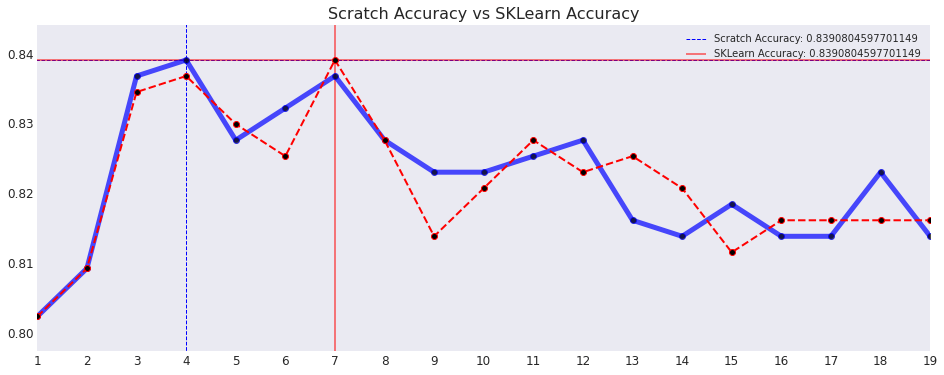

In [110]:
def plot_comparision(X, scores1, scores2, beta=0.1, t=1, name1="Scratch Accuracy", name2="SKLearn Accuracy"):
    plt.figure(figsize=(16,6))
    plt.plot(X, scores1, color = 'blue', marker="o", markerfacecolor='black', lw=5, alpha=0.7)
    plt.plot(X, scores2, color = 'red', marker="o", markerfacecolor='black', linestyle='dashed', lw=2)
    plt.xticks(X)
    plt.hlines(max(scores1),0, max(X), color="blue", lw=1, ls="--", label=f"{name1}: {max(scores1)}")
    plt.vlines(scores1.index(max(scores1))*t + 1, 0, 1, color="blue", lw=1, ls="--")
    plt.hlines(max(scores2),0, max(X), color="red", lw=2, alpha=0.5, label=f"{name2}: {max(scores2)}")
    plt.vlines(scores2.index(max(scores2))*t + 1, 0, 1, color="red", lw=2, alpha=0.5)
    plt.axis([min(X),max(X),min(scores1) - beta ,max(scores1) + beta])
    plt.title(f"{name1} vs {name2}")
    plt.legend()
    plt.show()

plot_comparision(depths, tree_scores, sk_tree_scores, beta=0.005)

In [21]:
class RandomForest:
    def __init__(self, n_estimators=21, min_samples_leaf=20, max_depth=4, n_feats=None, **kwargs):
        self.n_trees = n_estimators
        self.min_sample = min_samples_leaf
        self.max_depth = max_depth
        self.n_feats = n_feats
        
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_leaf=self.min_sample, max_depth=self.max_depth, n_feats=self.n_feats)
            X_sample, y_sample = self.bootstrap(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
     
    def predict(self, X):
        forest_pred = np.swapaxes(np.array([tree.predict(X) for tree in self.trees]), 0,1)
        y_pred = [DecisionTree.majority_vote(pred, b=True) for pred in forest_pred]
        
        return np.array(y_pred)
        
    def bootstrap(self, X, y):
        n_samples = X.shape[0]
        idx = np.random.choice(n_samples, size=n_samples, replace=True)
        
        return X[idx], y[idx]

In [125]:
forest = RandomForest(n_estimators=11)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
print("Scratch Random Forest Accuracy: ", accuracy_score(forest_pred, y_test))

Scratch Random Forest Accuracy:  0.8482758620689655


In [120]:
from sklearn.ensemble import RandomForestClassifier
sk_forest = RandomForestClassifier(criterion='entropy',n_estimators=15,min_samples_leaf=19, max_depth=20, max_features=None, random_state=42)
sk_forest.fit(X_train, y_train)
sk_forest_pred = sk_forest.predict(X_test)
print("SKLearn Random Forest Accuracy: ", accuracy_score(sk_forest_pred, y_test))

SKLearn Random Forest Accuracy:  0.8436781609195402


In [90]:
def get_forest_scores(classifier, n_estimators, X_train, X_test, y_train, y_test):
    scores = []
    for n in n_estimators:
        FOREST = classifier(min_samples_leaf=2, max_depth=d, random_state=42, criterion='entropy')
        FOREST.fit(X_train, y_train)
        y_pred = FOREST.predict(X_test)
        score = accuracy_score(y_pred, y_test)
        scores.append(score)
    
    return scores

n_estimators = np.arange(1,39,2)
forest_scores = get_scores(RandomForest, n_estimators, X_train, X_test, y_train, y_test)
sk_forest_scores = get_scores(RandomForestClassifier, n_estimators, X_train, X_test, y_train, y_test)

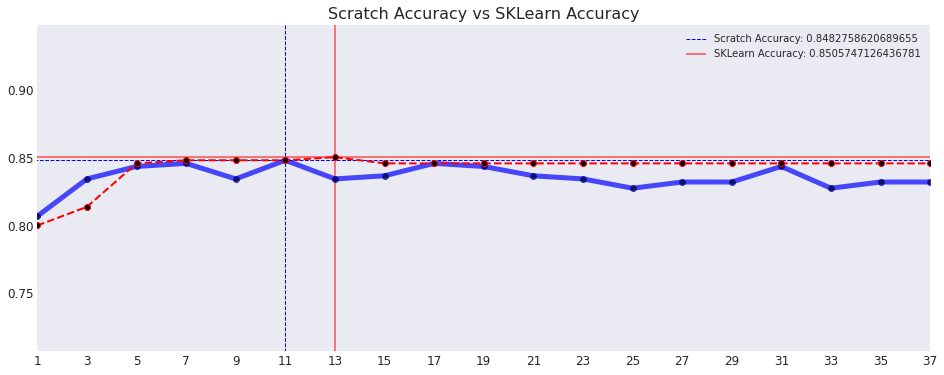

In [111]:
plot_comparision(n_estimators, forest_scores, sk_forest_scores, t=2, name1="Scratch Accuracy", name2="SKLearn Accuracy")